## Data Preparation

In [1]:
import pandas as pd
file_path = "Team Information Individual Project.xlsx"
df = pd.read_excel(file_path)
df.head()
df.columns

Index(['yearID', 'lgID', 'teamID', 'franchID', 'G', 'W', 'L', 'R', 'AB', 'H',
       '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER',
       'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E',
       'DP', 'FP', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro'],
      dtype='object')

In [2]:
#Team Statistic calculations: including batting average, on base percentage, singles, total bases, slugging,
# run differential, and win percentage
#batting average: hits / at bats
df['AVG'] = df['H'] / df['AB']
# on base percentage: (hits + walks + hit by pitch) / (at bats + walks + hit by pitch + sac flys)
df['OBP'] = (df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['HBP'] + df['SF'])
# singles: hits - (doubles + triples + home runs)
df['1B'] = df['H'] - (df['2B'] + df['3B'] + df['HR'])
# total bases = single + (2 * doubles) + (3 * triples) + (4 * home runs)
# total bases adds weighted values for amount of bases for each type of hit
df['TB'] = df['1B'] + (2 * df['2B']) + (3 * df['3B']) + (4 * df['HR'])
# slugging = total bases / at bats
df['SLG'] = df['TB'] / df['AB']
# run differential = runs scored - runs allowed
df['RunDiff'] = df['R'] - df['RA']
# win percentage = wins / (wins + losses)
df['WinPct'] = df['W'] / (df['W'] + df['L'])
df[['yearID','teamID','AVG','OBP','SLG','WinPct','RunDiff']].head()

,yearID,teamID,AVG,OBP,SLG,WinPct,RunDiff
0,2000,ANA,0.279673,0.352355,0.472459,0.506173,-5
1,2000,ARI,0.265243,0.333387,0.429347,0.524691,38
2,2000,ATL,0.271452,0.346477,0.428676,0.586420,96
3,2000,BAL,0.271761,0.340580,0.435033,0.456790,-119
4,2000,BOS,0.266963,0.340547,0.423446,0.524691,47


## Experiment 1: Full Model (All predictors)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

#define the predictor variables (offensive and defensive stats)
predictors = ['R','RA','HR','OBP','SLG','AVG', 'ERA', 'E', 'RunDiff']
#features
X = df[predictors]
#target
y = df['WinPct']

# split data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#initialize and fit a multiple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
#predict winning percentage on the test set
y_pred = model.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R²: 0.8602097357385099
MSE: 0.0007593688494131767


In [4]:
# displays the coefficient values from the linear regression model
coeffs = pd.Series(model.coef_, index=predictors).sort_values(ascending=False)
coeffs

OBP        0.786129
SLG        0.466071
RunDiff    0.000240
R          0.000125
HR         0.000017
RA        -0.000115
E         -0.000247
ERA       -0.046185
AVG       -0.304431
dtype: float64

### Scaled version of model (scaled coefficients, easier to compare)

In [5]:
from sklearn.preprocessing import StandardScaler
#name predictors
predictors = ['R','RA','HR','OBP','SLG','AVG','ERA','E', 'RunDiff']
#features
X = df[predictors]
#target
y = df['WinPct']
#initialise and fit the scaler to X and transform the predictor values
# scaling the features standardizes each column: subtracts the mean and divides by the standard dev.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#convert the scaled array back to a dictionary
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors, index=df.index)
X_scaled_df.head()


,R,RA,HR,OBP,SLG,AVG,ERA,E,RunDiff
0,1.175664,1.172793,1.590569,1.815572,2.118140,1.666692,1.372785,1.806229,-0.044566
1,0.595008,0.278301,0.209557,0.523235,0.536067,0.588815,0.190849,0.511797,0.338699
2,0.740172,-0.032826,0.209557,1.415070,0.511433,1.052591,-0.354660,1.566519,0.855661
3,0.611138,1.515033,0.330698,1.013271,0.744742,1.075649,2.045579,0.943275,-1.060663
4,0.595008,0.208298,-0.081182,1.011010,0.319521,0.717248,-0.027355,0.607681,0.418917


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#split the scaled dataset into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# extracting the fitted coefficients for each predictor
#pair them with predictor names and sort descending to see positive influence on win percentage
coeffs = pd.Series(model.coef_, index=predictors).sort_values(ascending=False)
coeffs


R²: 0.8602097357385083
MSE: 0.0007593688494131854


RunDiff    0.028964
R          0.013322
SLG        0.012701
OBP        0.011538
HR         0.000709
AVG       -0.004075
E         -0.005161
RA        -0.012427
ERA       -0.025399
dtype: float64

## Experiment 2: Offense and Defense

In [7]:
#define offensive predictors (runs, on base percentage, slugging, average)
offense_predictors = ['R','OBP','SLG','AVG']
X_offense = df[offense_predictors]
# scale the offensive predictors so each has a mean of 0 and a std dev of 1
X_offense_scaled = scaler.fit_transform(X_offense)

#define defensive predictors (runs allowed, earned run average, errors)
defense_predictors = ['RA','ERA','E']
X_defense = df[defense_predictors]
X_defense_scaled = scaler.fit_transform(X_defense)

#two separate regressions, one for offense and one for defense
#both split training and testing data and fitting separate regression models to test effect on win %
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_offense_scaled, y, test_size=0.2, random_state=42)
model_offense = LinearRegression().fit(X_train_o, y_train_o)
print("Offense R²:", r2_score(y_test_o, model_offense.predict(X_test_o)))

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_defense_scaled, y, test_size=0.2, random_state=42)
model_defense = LinearRegression().fit(X_train_d, y_train_d)
print("Defense R²:", r2_score(y_test_d, model_defense.predict(X_test_d)))


Offense R²: 0.43512563085855394
Defense R²: 0.4571649549736976


## Experiment 3: Era-Specific Models

In [8]:
#create a new column that bins era into three separate groups
df['Era'] = pd.cut(df['yearID'], bins=[1999,2009,2015,2022], labels=['2000s','2010-15','2016-22'])

#runs regression for each individual era
def run_regression_for_era(era_label):
    #filter the dataframe to only include rows from the era
    era_df = df[df['Era'] == era_label]
    #predictors
    X_era = era_df[predictors]
    #target
    y_era = era_df['WinPct']
    
    #standardize predictors so coefficients can be compared
    X_era_scaled = scaler.fit_transform(X_era)

    #fit a linear regression model to this era
    model_era = LinearRegression().fit(X_era_scaled, y_era)
    #extract coefficients
    coeffs = pd.Series(model_era.coef_, index=predictors).sort_values(ascending=False)
    print(f"\nEra: {era_label}")
    print("R²:", model_era.score(X_era_scaled, y_era))
    print(coeffs)

#loops through each era and runs regression and prints coefficients
for era in df['Era'].unique():
    run_regression_for_era(era)



Era: 2000s
R²: 0.8851213699720057
RunDiff    0.022890
HR         0.017362
R          0.016741
AVG        0.009646
OBP        0.007410
E         -0.002618
RA        -0.014250
SLG       -0.014316
ERA       -0.019921
dtype: float64

Era: 2010-15
R²: 0.8885246184276843
RunDiff    0.017728
R          0.014702
SLG        0.008971
OBP        0.004123
AVG        0.001389
HR         0.001365
E         -0.001851
RA        -0.010282
ERA       -0.027176
dtype: float64

Era: 2016-22
R²: 0.8889225933186998
SLG        0.028075
RunDiff    0.025823
R          0.017784
OBP        0.007350
RA        -0.000843
E         -0.009324
AVG       -0.009825
HR        -0.012571
ERA       -0.039030
dtype: float64


## Plots

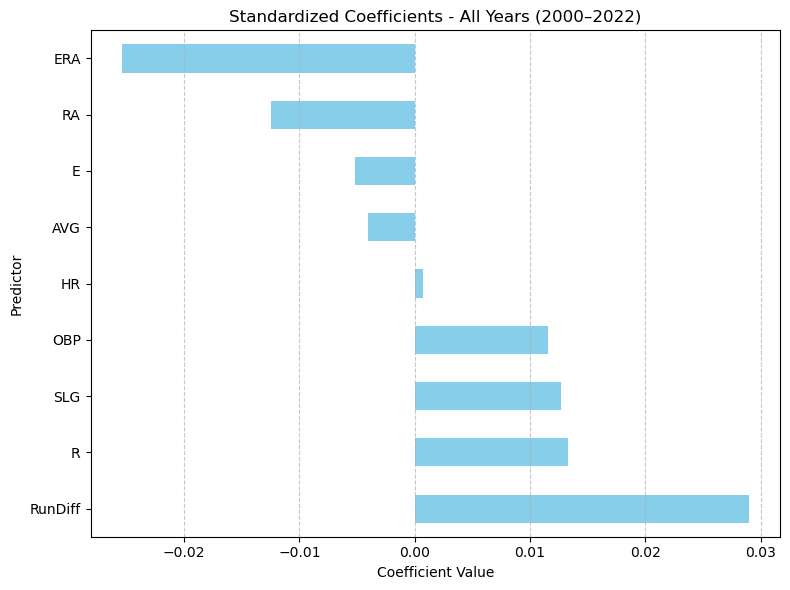

In [9]:
import matplotlib.pyplot as plt

#produces a bar chart showing the regression coefficients for all predictors across the entire dataset
#the bar length shows the standardized coefficient value (how strongly the predictor influences win %)
#the positive bars show predictors that increase win % while the negative decrease win %
coeffs.plot(kind='barh', figsize=(8,6), color='skyblue')
plt.title("Standardized Coefficients - All Years (2000–2022)")
plt.xlabel("Coefficient Value")
plt.ylabel("Predictor")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


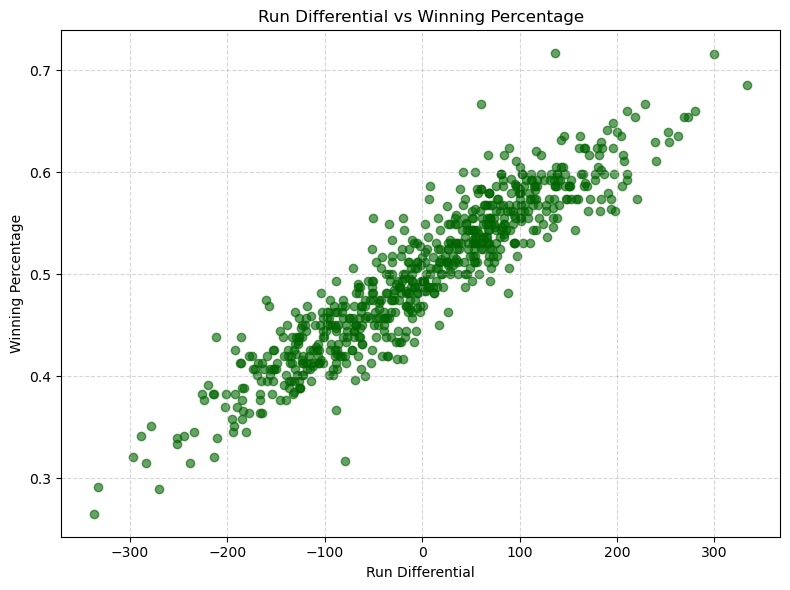

In [10]:
#shows a scatterplot that shows the relationship between run differential and win % for all teams
#each point represents a team season
plt.figure(figsize=(8,6))
plt.scatter(df['RunDiff'], df['WinPct'], alpha=0.6, color='darkgreen')
plt.title("Run Differential vs Winning Percentage")
plt.xlabel("Run Differential")
plt.ylabel("Winning Percentage")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


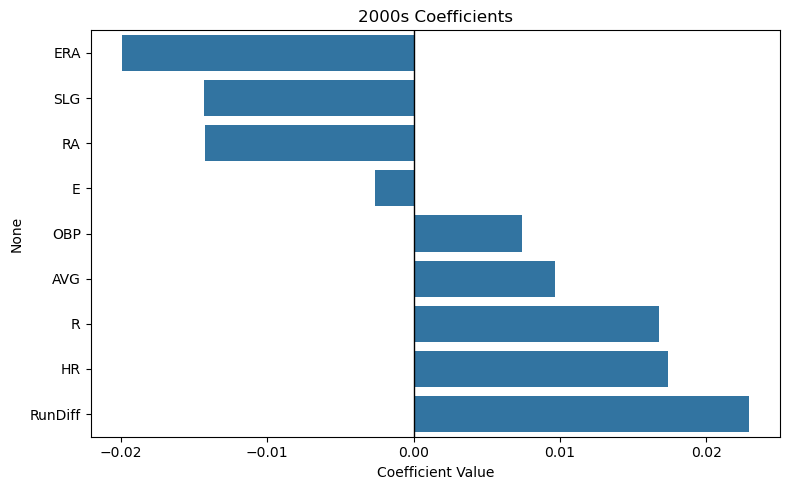

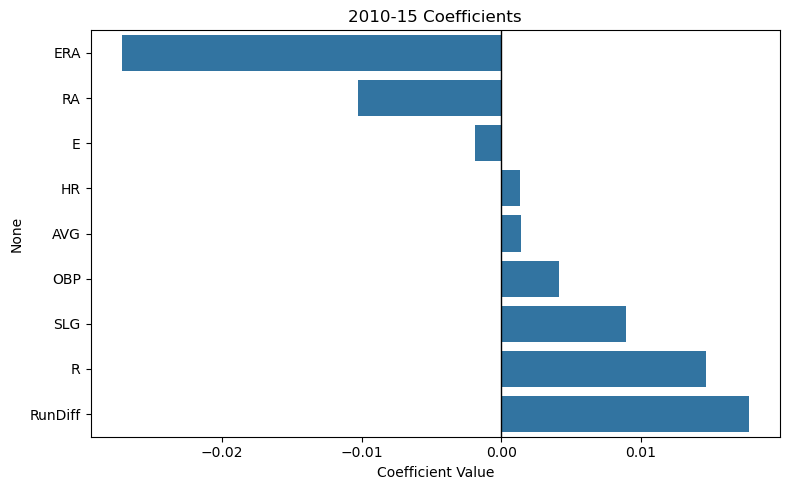

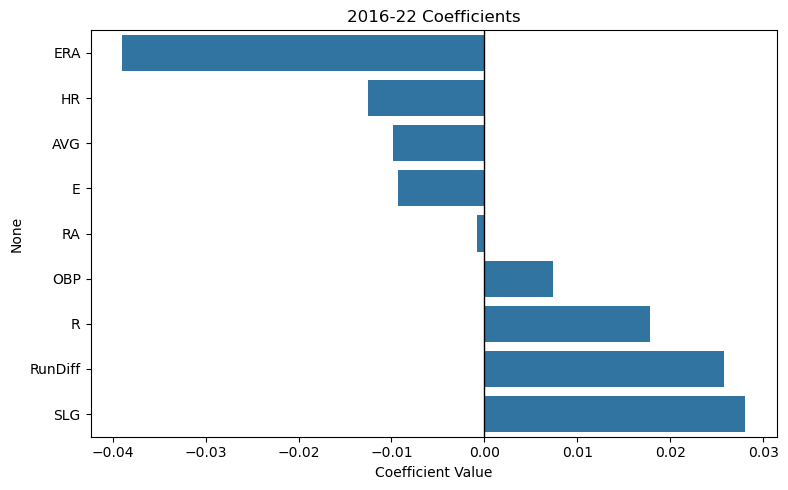

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# dictionary to store coefficients for each era
era_results = {}

# looping through each era
for era in df['Era'].unique():
    # Filter the dataframe to only include rows from the current era
    era_df = df[df['Era'] == era]
    
    # selects predictors and target
    X_era = era_df[predictors]
    y_era = era_df['WinPct']
    
    # standardizes predictors 
    X_era_scaled = scaler.fit_transform(X_era)
    
    # fit a linear regression model for this era and extract coefficients
    model_era = LinearRegression().fit(X_era_scaled, y_era)
    coeffs = pd.Series(model_era.coef_, index=predictors).sort_values()

    era_results[era] = coeffs

    # ---- plot individually ----
    plt.figure(figsize=(8, 5))
    sns.barplot(x=coeffs.values, y=coeffs.index)
    plt.title(f"{era} Coefficients")
    plt.xlabel("Coefficient Value")
    plt.axvline(0, color='black', linewidth=1)
    plt.tight_layout()
    plt.show()
